###In this notebook we attempt to classify between text from Seinfeld and Friends, using both classical models (Logistic Regression, Naive Bayes) and Deep Learning, and compare and analyze the results.

In [ ]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding, MaxPooling1D, BatchNormalization
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Input

In [ ]:
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/nlp_train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/nlp_test.csv")
df



,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9


In [ ]:
# Let's see how many samples we have of each show
df['Show'].value_counts()


Friends     39092
Seinfeld    31313
Name: Show, dtype: int64

<BarContainer object of 10 artists>

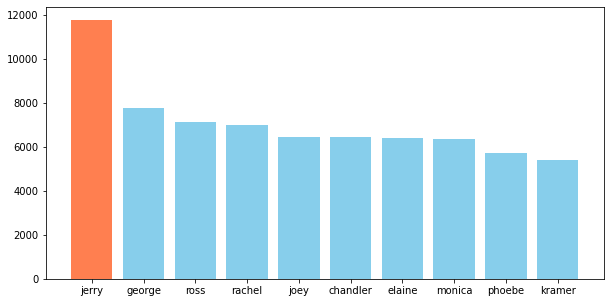

In [ ]:
# Let's see which characters appear the most in this data set
counts = dict(df['Character'].value_counts())
plt.figure(figsize = (10, 5))
plt.bar(counts.keys(), counts.values(), color = ["coral" if not i else "skyblue" for i in range(len(counts.values()))])


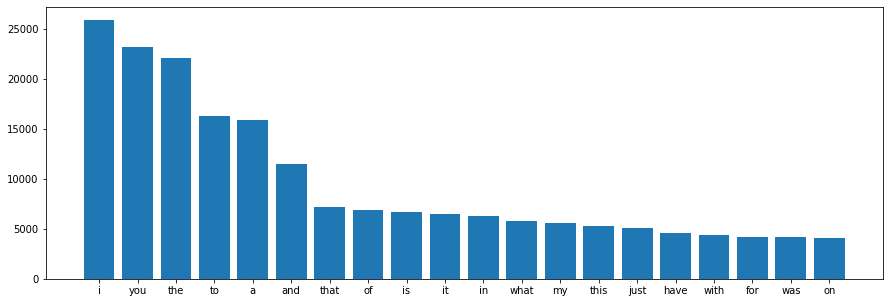

In [ ]:
# Let's check which words are most common in our dataset

def count_words(col):
  results = Counter()
  col.str.lower().str.split().apply(results.update)
  words, counts = zip(*[(word, count) for word, count in results.most_common(20)])
  plt.figure(figsize=(15,5))
  plt.bar(words, counts)


count_words(df['Dialogue'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

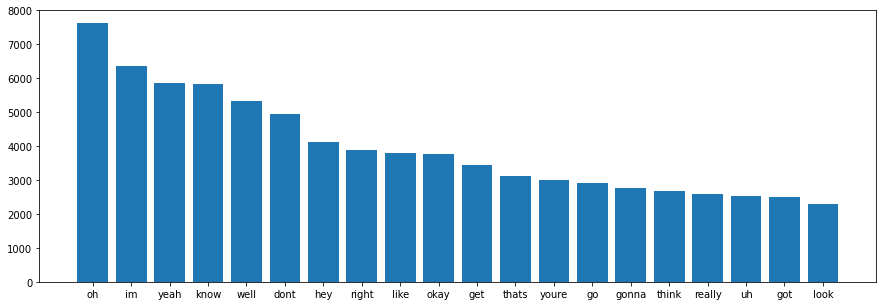

In [ ]:
# As we can see, most of the most common words are "stop words", which are very common and thus hold very little meaning to the models we'll be using,
# let's see which words are most common after removing stop words from our text. We'll also remove any special characters.

def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

df['Dialogue'] = df['Dialogue'].apply(remove_special_characters)
test_df['Dialogue'] = test_df['Dialogue'].apply(remove_special_characters)

nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

tokenizer = ToktokTokenizer()
tqdm.pandas()

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

df['Dialogue'] = df['Dialogue'].progress_apply(remove_stopwords)
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(remove_stopwords)

count_words(df['Dialogue'])

In [ ]:
# Finally, we'll stem the text to further reduce our data's dimensionality

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    stemmed_words_list = []
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text
# Apply function on review column
df['Dialogue'] = df['Dialogue'].progress_apply(simple_stemmer)
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(simple_stemmer)
df['Dialogue'][:10]

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

0                                                  hey
1                  joey gonna embarrass go noth prepar
2                    your gonna tell Im gonna tell noo
3    alright guy parti number one [ usher 3 guy mon...
4                                       sane blew mind
5    your parent hadnt got divorc youd abl answer q...
6                                                 what
7    overenthusiast dont know know tri get young mi...
8         know alway want first black man cross atlant
9                                    uniform what made
Name: Dialogue, dtype: object

In [ ]:
X = df['Dialogue']
y = df['Show']

In [ ]:
# Train test split

X_train, y_train = X, y
X_test, y_test = test_df['Dialogue'], test_df['Show']
y_train = y_train.apply(lambda x: 1 if x == 'Seinfeld' else 0)
y_test = y_test.apply(lambda x: 1 if x == 'Seinfeld' else 0)

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (70405,)
y_train shape: (70405,)
x_test shape: (4245,)
y_test shape: (4245,)


Let's see how more classical models such as Logistic Regression and Naive Bayes will perform on our data.

In [ ]:
# Let's use bag of words representation for our baseline

cv = CountVectorizer(analyzer='word')

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

print('x_train_cv:', X_train_cv.shape)
print('x_test_cv:', X_test_cv.shape)



x_train_cv: (70405, 17607)
x_test_cv: (4245, 17607)


In [ ]:
# Let's try using tf-idf as well

tv = TfidfVectorizer(analyzer='word', max_features=5000)

X_train_tf = tv.fit_transform(X_train)
X_test_tf = tv.transform(X_test)

print('x_train_tv:', X_train_tf.shape)
print('x_test_tv:', X_test_tf.shape)

x_train_tv: (70405, 5000)
x_test_tv: (4245, 5000)


In [ ]:
def evaluate(model, model_name, x, y, scores_dict=None, roc_dict=None):
  y_pred = model.predict(x)
  y_pred_proba = model.predict_proba(x)[:, 1] 

  scores_dict[model_name] = {}
  scores_dict[model_name]['AUC'] = roc_auc_score(y, y_pred_proba)
  scores_dict[model_name]['Accuracy'] =  accuracy_score(y, y_pred)

  roc_dict[model_name] = {}
  roc_dict[model_name]['FPR'], roc_dict[model_name]['TPR'], _ = roc_curve(y, y_pred_proba)

  return scores_dict

scores_dict = {}
roc_dict = {}


In [ ]:
lr_bow = LogisticRegression(penalty='l2', max_iter=500, random_state=41)
lr_bow.fit(X_train_cv, y_train.ravel())
lr_tf = LogisticRegression(penalty='l2', max_iter=500, random_state=41)
lr_tf.fit(X_train_tf, y_train.ravel())

LogisticRegression(max_iter=500, random_state=41)

In [ ]:
multiNB_bow = MultinomialNB()
multiNB_bow.fit(X_train_cv, y_train.ravel())
multiNB_tf = MultinomialNB()
multiNB_tf.fit(X_train_tf, y_train.ravel())

MultinomialNB()

In [ ]:
compNB_bow = ComplementNB()
compNB_bow.fit(X_train_cv, y_train.ravel())
compNB_tf = ComplementNB()
compNB_tf.fit(X_train_tf, y_train.ravel())

ComplementNB()

In [ ]:
evaluate(lr_bow, 'logistic_bow', X_test_cv, y_test, scores_dict, roc_dict)['logistic_bow']['Accuracy']
evaluate(multiNB_bow, 'multiNB_bow', X_test_cv, y_test, scores_dict, roc_dict)['multiNB_bow']['Accuracy']
evaluate(compNB_bow, 'compNB_bow', X_test_cv, y_test, scores_dict, roc_dict)['compNB_bow']['Accuracy']
evaluate(lr_tf, 'logistic_tf', X_test_tf, y_test, scores_dict, roc_dict)['logistic_tf']['Accuracy']
evaluate(multiNB_tf, 'multiNB_tf', X_test_tf, y_test, scores_dict, roc_dict)['multiNB_tf']['Accuracy']
evaluate(compNB_tf, 'compNB_tf', X_test_tf, y_test, scores_dict, roc_dict)['compNB_tf']['Accuracy']

0.8395759717314487

In [ ]:
# As we can see, BOW representation leads to better results, however it seems individually the models perfom pretty close to each other.

pd.DataFrame.from_dict(scores_dict).T

,AUC,Accuracy
logistic_bow,0.926440,0.852297
multiNB_bow,0.936403,0.857951
compNB_bow,0.936403,0.857008
logistic_tf,0.922103,0.844759
multiNB_tf,0.924543,0.837691
compNB_tf,0.924543,0.839576


###Now let's try using a neural network###


In [ ]:
# Since we would like to track how our neural network learns, let's split our training data into training and validation data

X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

print('x_train shape:', X_train_dl.shape)
print('y_train shape:', y_train_dl.shape)
print('x_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('x_val shape:', X_val_dl.shape)
print('y_val shape:', y_val_dl.shape)

x_train shape: (56324,)
y_train shape: (56324,)
x_test shape: (4245,)
y_test shape: (4245,)
x_val shape: (14081,)
y_val shape: (14081,)


In [ ]:
token = Tokenizer(lower=False)
token.fit_on_texts(X_train_dl)

In [ ]:
X_train_dl = token.texts_to_sequences(X_train_dl)
X_val_dl = token.texts_to_sequences(X_val_dl)
X_test_dl = token.texts_to_sequences(X_test)


Longest document length: 185 
 Shortest document length: 0 
 Mean document length: 5.82579362261203


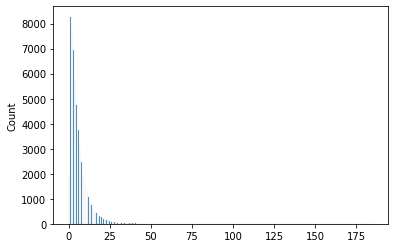

In [ ]:
# Since our neural network will have a fixed input size, we'll gauge what size we should use
# by looking at some descriptive statistics of our word lengths

doc_len_list = [len(doc) for doc in X_train_dl]
print(f"Longest document length: {max(doc_len_list)} \n Shortest document length: {min(doc_len_list)} \n Mean document length: {np.mean(doc_len_list)}")
sns.histplot(doc_len_list)



In [ ]:
# Let's try a cutoff of 40

max_words = 40

X_train_dl = sequence.pad_sequences(X_train_dl, maxlen=max_words)
X_val_dl = sequence.pad_sequences(X_val_dl, maxlen=max_words)
X_test_dl = sequence.pad_sequences(X_test_dl, maxlen=max_words)


In [ ]:
total_words = len(token.word_index) + 1 
total_words

15844

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim = 30, input_length = max_words))
model.add(Conv1D(filters = 128, kernel_size = 2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size = 2, strides=2, padding='valid'))
model.add(Conv1D(256, 2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid'))
model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 30)            475320    
                                                                 
 conv1d (Conv1D)             (None, 40, 128)           7808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 256)           65792     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 256)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 2560)              0

In [ ]:
model.fit(X_train_dl, y_train_dl, validation_data=(X_val_dl, y_val_dl), epochs = 2, batch_size = 16)


Epoch 1/2
3521/3521 [==============================] - 56s 16ms/step - loss: 0.5264 - accuracy: 0.7015 - val_loss: 0.4873 - val_accuracy: 0.7327
Epoch 2/2
3521/3521 [==============================] - 53s 15ms/step - loss: 0.4429 - accuracy: 0.7679 - val_loss: 0.4886 - val_accuracy: 0.7408


In [ ]:
model.evaluate(X_test_dl, y_test)


133/133 [==============================] - 1s 5ms/step - loss: 0.3401 - accuracy: 0.8490


[0.3401425778865814, 0.8489988446235657]

####After a lot of experimentation with the NN architecture, we found that two Conv1D layers with increasing filter amount and max pooling in between worked the best. We also noticed that the NN learns extremely fast (1-2 epochs before overfitting). Since it learns so fast, we also included pretty heavy regularization (Dropout with 65%) before the output neuron. We tried dropout/batch normalization layers between the two conv layers however this did not perform as well. Lastly, we found that keeping the input sequence length to 40 and then embedding them to a size of 30 worked best. While this is far from the average document length of 5.8, it makes sense to keep the extra words since for a task such as this they probably hold the most information (specific characteristics of each character rather than plain English sentences such as "Hey how are you doing?").Interestingly, the most effective model ended up being logistic regression / naive bayes (with bag of words), surpassing the NN accuracy by more than 1% (85.79% for multinomial naive bayes) with much faster training and inference time !####

###Let's see which characters tripped up our models the most###

In [ ]:
def graph_prediction_ratios(X, test_data, clf, is_dl = 0):
  graph_test_df = test_data.copy()
  if is_dl:
      preds = map(lambda x: 1 if x >= 0.5 else 0, list(clf.predict(X, verbose=1)))
  else:
      preds = clf.predict(X)
  graph_test_df['prediction'] = list(preds)
  graph_test_df['Show'] = graph_test_df['Show'].apply(lambda x: 1 if x == 'Seinfeld' else 0)
  graph_test_df['is_right'] = np.where(graph_test_df['Show'] == graph_test_df['prediction'], 1, 0)
  graph_df = graph_test_df[['Character', 'is_right']]
  correct_ratio = graph_df.groupby(by = 'Character').sum() / graph_df.groupby(by = 'Character').count()
  correct_ratio = correct_ratio.reset_index(level=0)
  correct_ratio = correct_ratio.sort_values(by = 'is_right', ascending = False)
  plt.figure(figsize = (10, 5))
  bars = plt.bar(correct_ratio['Character'], correct_ratio['is_right'], color = ['skyblue' if i in ['jerry', 'kramer', 'george', 'elaine'] else 'coral' for i in (correct_ratio['Character'])])
  plt.xlabel('Character')
  plt.ylabel('Ratio of correct predictions')
  plt.title(f'Percentage of correct predictions per character')
  # assign your bars to a variable so their attributes can be accessed
  # access the bar attributes to place the text in the appropriate location
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + 0.15, yval + .005, np.around(yval, 2))
  plt.figure(figsize = (1, 1))
  plt.show()


NN:

133/133 [==============================] - 1s 7ms/step


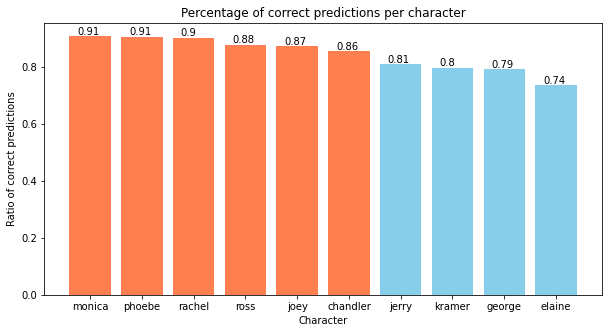

<Figure size 72x72 with 0 Axes>

Logistic Regression bag of words: 



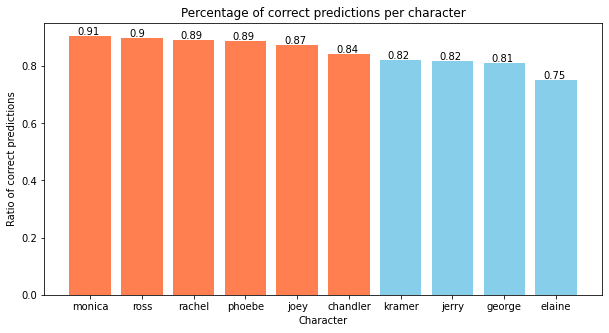

<Figure size 72x72 with 0 Axes>

Logistic Regression tf-idf: 



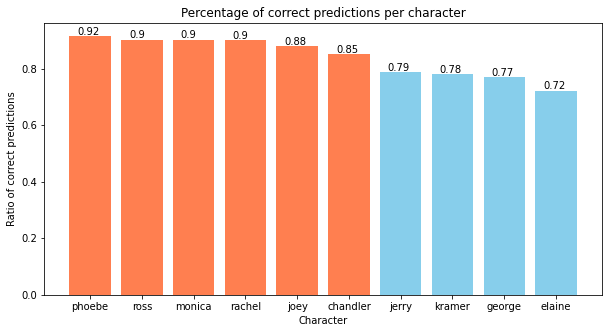

<Figure size 72x72 with 0 Axes>

Multinomial Naive Bayes' bag of words: 



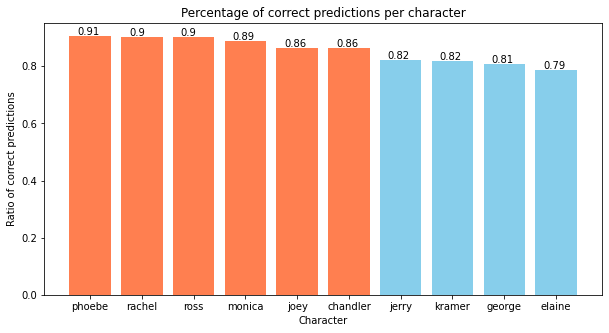

<Figure size 72x72 with 0 Axes>

Multinomial Naive Bayes tf-idf: 



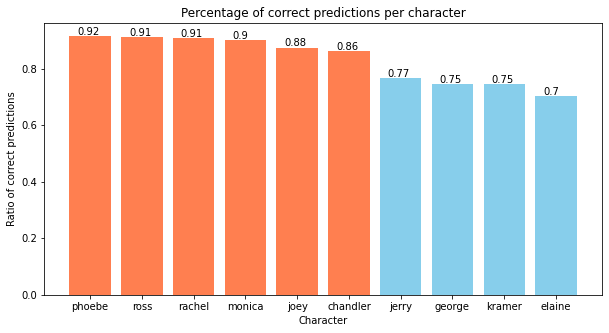

<Figure size 72x72 with 0 Axes>

Complement Naive Bayes bag of words: 



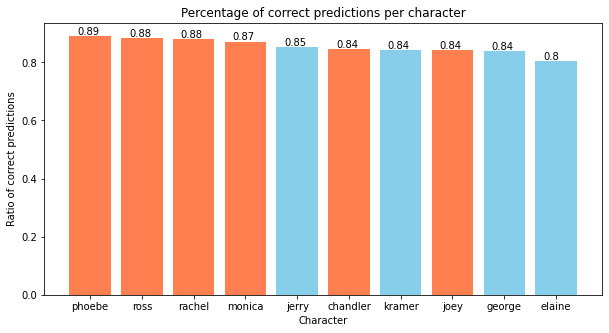

<Figure size 72x72 with 0 Axes>

Complement Naive Bayes tf-idf: 



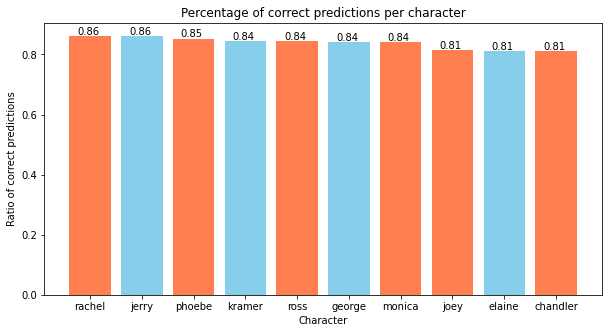

<Figure size 72x72 with 0 Axes>

In [ ]:
print("NN:\n")
graph_prediction_ratios(X_test_dl, test_df, model, 1)
print("Logistic Regression bag of words: \n")
graph_prediction_ratios(X_test_cv, test_df, lr_bow)
print("Logistic Regression tf-idf: \n")
graph_prediction_ratios(X_test_tf, test_df, lr_tf)
print("Multinomial Naive Bayes' bag of words: \n")
graph_prediction_ratios(X_test_cv, test_df, multiNB_bow)
print("Multinomial Naive Bayes tf-idf: \n")
graph_prediction_ratios(X_test_tf, test_df, multiNB_tf)
print('Complement Naive Bayes bag of words: \n')
graph_prediction_ratios(X_test_cv, test_df, compNB_bow)
print('Complement Naive Bayes tf-idf: \n')
graph_prediction_ratios(X_test_tf, test_df, compNB_tf)


As we can see, most models have an easier time predicting text from Friends rather than text from Seinfeld. This probably means that the text from Seinfeld is more "Generic" while Friends' text has more defining/unique charectaristics. It's also cool that characters like Jerry, Kramer and George are classified better, matching their "whackier" personalities in relation to Elaine's (We can't reference Friends' characters since we haven't seen it !).

In [ ]:
# Keep keys the same, and replace values according to your results and the specified type 

results = {'Test set accuracy' : [0.8490],
           'Train set accuracy': [0.7679] ,
           'Number of trainable parameters': [551481],
           'Number of layers': [8],
           'Regularization methods': ['Dropout'],
           'Number of epochs': [2],
           'Choice of loss function': ['Binary Crossentropy'],
           'Choice of optimizer': ['adam'],
           'Embedding dimension': [30]
           }

results = pd.DataFrame(results)
results

,Test set accuracy,Train set accuracy,Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Choice of loss function,Choice of optimizer,Embedding dimension
0,0.849,0.7679,551481,8,Dropout,2,Binary Crossentropy,adam,30


In [ ]:
from google.colab import files
import os

results.to_csv(os.path.join(os.getcwd(), 'exercise3.csv'))
files.download('exercise3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>